<a href="https://colab.research.google.com/github/MonicaKim89/sign_detection/blob/main/%5B0721%5Dstill_learning_Resnet__up_fragile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import math
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras import optimizers


# IMG_SIZE = 100
# NUM_EPOCHS = 20
# NUM_CLASSES = 2
# TRAIN_BATCH_SIZE = 77
# TEST_BATCH_SIZE = 1 
# opt =  tf.optimizers.Adam()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def create_model():
  #resnet_weights_path = '/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5'
  #resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

  #weigths = weights=resnet_weights_path ->none
  resnet = ResNet50(include_top=False, pooling='avg', weights = None)
  #resnet.summary()
  my_new_model = Sequential()
  my_new_model.add(resnet)
  my_new_model.layers[0].trainable = True
  my_new_model.add(Dense(NUM_CLASSES, activation='softmax')) #dense 3, NUM_CLASSES = 3

  # Say no to train first layer (ResNet) model. It is already trained
    
  opt =  tf.optimizers.Adam()
   #opt바꾼거 확인해
  my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return my_new_model

In [4]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/fragile/Brand_new/dataset_workspace/class_dataset/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/fragile/Brand_new/dataset_workspace/class_dataset/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps = 1 
            #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return model, train_generator,validation_generator

In [5]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [6]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [7]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)

In [8]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()

In [9]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1]- 600 # 위치
    cv2.putText(frame, class_string, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [10]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [12]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        print(c)
        print(confidence)
        txt += label_dict[c]
        txt += '['+ str(confidence) +']'
    return txt
    # txt = neutral[0.38]

In [13]:
def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        print('pred_vec')
        print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        pc = pred_vec.argmax()
        pred_class.append( (pc, confidence) )

        if pred_class:
            txt = get_display_string(pred_class, label_dict)
            print('최종txt' +txt)       
            frame = draw_prediction( frame, txt )
            #print('pred_class')
            #print(pred_class)
            #print('label_dict')
            #print(label_dict)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
        writer.write(frame)
        
    vs.release()
    writer.release()

In [14]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Found 5938 images belonging to 2 classes.
Found 744 images belonging to 2 classes.
Epoch 1/20
77/77 [==============================] - 2000s 26s/step - loss: 1.0426 - accuracy: 0.7149 - val_loss: 0.8150 - val_accuracy: 0.0000e+00
Epoch 2/20
77/77 [==============================] - 24s 307ms/step - loss: 0.2791 - accuracy: 0.8855 - val_loss: 0.5134 - val_accuracy: 1.0000
Epoch 3/20
77/77 [==============================] - 23s 299ms/step - loss: 0.1792 - accuracy: 0.9254 - val_loss: 0.0627 - val_accuracy: 1.0000
Epoch 4/20
77/77 [==============================] - 25s 318ms/step - loss: 0.1812 - accuracy: 0.9252 - val_loss: 0.0736 - val_accuracy: 1.0000
Epoch 5/20
77/77 [==============================] - 24s 315ms/step - loss: 0.1151 - accuracy: 0.9502 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/20
77/77 [==============================] - 24s 310ms/step - loss: 0.1092 - accuracy: 0.9539 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 7/20
77/77 [==============================] - 23s

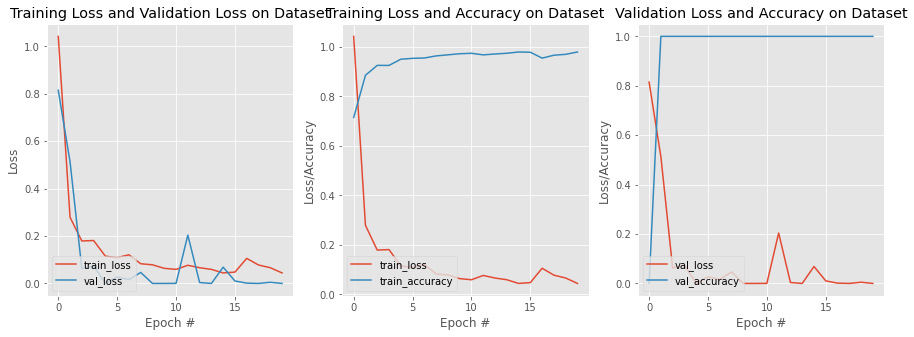

In [15]:
trained_model,train_generator,validation_generator = train_model(model)
label_dict= get_label_dict(train_generator)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.save('/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5')

In [19]:
label_dict

{0: 'fragile', 1: 'up'}

In [18]:
def plot_history2( H, NUM_EPOCHS ):
    acc = H.history['acc']
    val_acc = H.history['val_acc']

    loss = H.history['loss']
    val_loss = H.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.title('Trainin and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [16]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.save('/content/drive/MyDrive/fragile/Brand_new/0721resnet.h5')
model_json = model.to_json()

with open("model.json", "w") as json_file : 
    json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [50]:
%cd /content/drive/MyDrive/fragile/test_result

video_path = '/content/drive/MyDrive/fragile/test_result/fragile_test_video.mp4'
predict ( trained_model, video_path, '/content/drive/MyDrive/fragile/test_result/fragile_test_video.mp4',  label_dict) 

/content/drive/MyDrive/fragile/test_result


TypeError: ignored

## TEST

제기랄 어떻게 하는거냐

In [20]:
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [21]:

%cd /content/drive/MyDrive/fragile/Classification/Fragile_test

/content/drive/MyDrive/fragile/Classification/Fragile_test


In [36]:

import os
test_img_path = '/content/drive/MyDrive/fragile/Classification/Fragile_test/fragile_test/'
file_list = os.listdir(test_img_path)
file_list.sort
print(len(file_list))
list_file=[]
for i in file_list:
    list_file.append(test_img_path+i)
list_file.sort()
len(list_file)

18


18

In [37]:
file_name=[]
for i in list_file:
    name = i.split("/")[-1]
    file_name.append(name)
print(file_name[2])
print(len(file_name))

blankstock180501065.jpg
18


In [38]:
test_df = pd.DataFrame({'file_name':file_name})
nbsamples=test_df.shape[0]
nbsamples

18

In [44]:
# batch_size = 1
# data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                 width_shift_range=0.1,
#                                 height_shift_range=0.1,
#                                 #sear_range=0.01,
#                                 zoom_range=[0.9, 1.25],
#                                 horizontal_flip=False,
#                                 vertical_flip=False,
#                                 data_format='channels_last',
#                                 brightness_range=[0.5, 1.5])

In [58]:
test_generator1 = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/fragile/Brand_new/dataset_workspace/class_dataset/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')

Found 744 images belonging to 2 classes.


In [46]:
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# earlystop = EarlyStopping(patience=10)
# learning_rate_reduction=ReduceLROnPlateau(
#                         monitor= "val_accuracy", 
#                         patience = 2, 
#                         factor = 0.5, 
#                         min_lr=0.0001,
#                         verbose=1)
                        
# callbacks = [earlystop, learning_rate_reduction]

In [ ]:
print("-- Predict --")
output = model.predict_generator(test_generator1, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator1.class_indices)
print(output)

In [71]:
test_df['category']=np.argmax(predict, axis=1)
test_df['category']=test_df['category'].replace({0:'up',1:"fragile"})
test_df

,file_name,category
0,338.jpg,up
1,444.jpg,up
2,blankstock180501065.jpg,fragile
3,grunge-fragile-box-sign-with-arrow-up-on-piece...,up
4,images (1).jpg,up
5,images.jpg,fragile
6,logistic_sign_test (1).jpg,up
7,logistic_sign_test (10).jpg,up
8,logistic_sign_test (11).jpg,fragile
9,logistic_sign_test (12).jpg,up


In [70]:
test_df.category.value_counts()

fragile    9
up         9
Name: category, dtype: int64

## TEST2

In [73]:
from keras.models import load_model
imported_model = load_model('/content/drive/MyDrive/fragile/Brand_new/0721resnet.h5')

In [75]:
test_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/fragile/Brand_new/dataset_workspace/class_dataset/val',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')

Found 742 images belonging to 2 classes.


In [76]:
pred_vec = imported_model.predict_generator(test_generator,
                                            steps=test_generator.n,  #test_generator.batch_size
                                            verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


742/742 [==============================] - 263s 338ms/step


In [78]:
test_df['category'] = np.argmax(pred_vec, axis=1)
test_df['category']=test_df['category'].replace({0:'up',1:"fragile"}) 
test_df.shape()

ValueError: ignored

## TEST 3

In [ ]:
from keras.models import model_from_json 
json_file = open("model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close()
 
loaded_model = model_from_json(loaded_model_json)

In [ ]:
loaded_model.load_weights("model.h5") 

print("Loaded model from disk")

In [ ]:
loaded_model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

# model evaluation
score = loaded_model.evaluate(X,Y,verbose=0)

In [6]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = imported_model.predict(images, batch_size=10)

  print(classes[0])

#   if classes[0]>0:
#     print(fn + " is a dog")
#   else:
#     print(fn + " is a cat")

Saving resized_logistic_sign_test (11).jpg to resized_logistic_sign_test (11).jpg
[0.9192758  0.08072414]


ValueError: ignored

In [8]:
print(classes[0])

[0.9192758  0.08072414]
